In [1]:
import glob

all_filenames = glob.glob('data/names/*.txt')
print(all_filenames)

['data/names\\Arabic.txt', 'data/names\\Chinese.txt', 'data/names\\Czech.txt', 'data/names\\Dutch.txt', 'data/names\\English.txt', 'data/names\\French.txt', 'data/names\\German.txt', 'data/names\\Greek.txt', 'data/names\\Irish.txt', 'data/names\\Italian.txt', 'data/names\\Japanese.txt', 'data/names\\Korean.txt', 'data/names\\Polish.txt', 'data/names\\Portuguese.txt', 'data/names\\Russian.txt', 'data/names\\Scottish.txt', 'data/names\\Spanish.txt', 'data/names\\Turkish.txt', 'data/names\\Vietnamese.txt']


In [2]:
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'"
n_letters = len(all_letters)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicode_to_ascii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

print(unicode_to_ascii('Ślusàrski'))

Slusarski


In [3]:
category_lines = {}
all_categories = []

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding="ISO-8859-1").read().strip().split('\n')
    return [unicode_to_ascii(line) for line in lines]

for filename in all_filenames:
    category = filename.split('/')[-1].split('.')[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)
print('n_categories =', n_categories) 


n_categories = 19


In [4]:
import torch

def letter_to_tensor(letter):
    tensor = torch.zeros(1, n_letters)
    letter_index = all_letters.find(letter)
    tensor[0][letter_index] = 1
    return tensor

def line_to_tensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li, letter in enumerate(line):
        letter_index = all_letters.find(letter)
        tensor[li][0][letter_index] = 1
    return  tensor    

In [5]:
print(letter_to_tensor('J'))



Columns 0 to 12 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 13 to 25 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 26 to 38 
    0     0     0     0     0     0     0     0     0     1     0     0     0

Columns 39 to 51 
    0     0     0     0     0     0     0     0     0     0     0     0     0

Columns 52 to 56 
    0     0     0     0     0
[torch.FloatTensor of size 1x57]



In [6]:
print(line_to_tensor('Furkan').size())

torch.Size([6, 1, 57])


In [7]:
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.softmax = nn.LogSoftmax()
        
    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden = self.i2h(combined)
        output = self.i2o(combined)
        output = self.softmax(output)
        return output, hidden
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [8]:
n_hidden = 128
rnn = RNN(n_letters, n_hidden, n_categories)

In [9]:
input = Variable(letter_to_tensor('A'))
hidden = rnn.init_hidden()

output, next_hidden = rnn(input, hidden)
print('output.size =', output.size())

output.size = torch.Size([1, 19])


In [10]:
input =  Variable(line_to_tensor('Furkan'))
hidden = Variable(torch.zeros(1, n_hidden))

output, next_hidden = rnn(input[0], hidden)
print(output)

Variable containing:

Columns 0 to 9 
-2.8793 -2.9766 -2.9214 -2.8627 -3.0481 -2.9694 -3.0046 -2.8606 -3.0026 -2.9232

Columns 10 to 18 
-2.9396 -2.9808 -3.0050 -2.8690 -3.0083 -2.9856 -2.8857 -2.9522 -2.8996
[torch.FloatTensor of size 1x19]



In [11]:
def category_from_output(output):
    top_n, top_i = output.data.topk(1)
    category_i = top_i[0][0]
    return all_categories[category_i], category_i

print(category_from_output(output))

('names\\Greek', 7)


In [12]:
import random

def random_training_pair():
    category = random.choice(all_categories)
    line = random.choice(category_lines[category])
    category_tensor = Variable(torch.LongTensor([all_categories.index(category)]))
    line_tensor = Variable(line_to_tensor(line))
    return category, line, category_tensor, line_tensor

for i in range(10):
    category, line, category_tensor, line_tensor = random_training_pair()
    print('category =', category, '/ line =', line)

category = names\Vietnamese / line = Tieu
category = names\Russian / line = Billert
category = names\Chinese / line = Sze 
category = names\Dutch / line = Vann
category = names\Scottish / line = Mclean
category = names\Scottish / line = Martin
category = names\Dutch / line = Asch
category = names\Japanese / line = Ishiyama
category = names\Polish / line = Walentowicz
category = names\French / line = SAverin


In [13]:
criterion = nn.NLLLoss()

In [14]:
learning_rate = 0.005
optimizer = torch.optim.SGD(rnn.parameters(), lr=learning_rate)

In [15]:
def train(category_tensor, line_tensor):
    rnn.zero_grad()
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
        
    loss = criterion(output, category_tensor)
    loss.backward()
    
    optimizer.step()
    
    return output, loss.data[0]

In [16]:
import time
import math

n_epochs = 100000
print_every = 5000
plot_every = 1000

current_loss = 0
all_losses = []

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

start = time.time()

for epoch in range(1, n_epochs + 1):
    category, line, category_tensor, line_tensor = random_training_pair()
    output, loss = train(category_tensor, line_tensor)
    current_loss += loss
    
    if epoch % print_every == 0:
        guess, guess_i = category_from_output(output)
        correct =  '✓' if guess == category else '✗ (%s)' % category
        print('%d %d%% (%s) %.4f %s / %s %s' % (epoch, epoch / n_epochs * 100, time_since(start), loss, line, guess, correct))
        
    if epoch % plot_every == 0:
        all_losses.append(current_loss / plot_every)
        current_loss = 0

5000 5% (0m 15s) 2.7477 Zoucha / names\Japanese ✗ (names\Czech)
10000 10% (0m 30s) 2.1466 Meral / names\Turkish ✓
15000 15% (0m 46s) 0.5113 Malihoudis / names\Greek ✓
20000 20% (1m 1s) 3.1735 Jans / names\Vietnamese ✗ (names\German)
25000 25% (1m 16s) 2.4844 Hutchings / names\Greek ✗ (names\English)
30000 30% (1m 31s) 0.8191 Ruvelas / names\Greek ✓
35000 35% (1m 47s) 1.2930 Matjeka / names\Polish ✗ (names\Czech)
40000 40% (2m 2s) 1.8819 YAksel / names\Polish ✗ (names\Turkish)
45000 45% (2m 18s) 2.5236 Olmos / names\Greek ✗ (names\Spanish)
50000 50% (2m 33s) 3.9071 Jimenez / names\German ✗ (names\Spanish)
55000 55% (2m 48s) 3.4688 Hiorvst / names\German ✗ (names\Czech)
60000 60% (3m 4s) 0.8183 Zellweger / names\German ✓
65000 65% (3m 19s) 1.7109 Adriyanoff / names\Italian ✗ (names\Russian)
70000 70% (3m 35s) 0.3265 Mustafa / names\Arabic ✓
75000 75% (3m 50s) 2.2958 Hassel / names\Arabic ✗ (names\Dutch)
80000 80% (4m 6s) 0.1797 Mesut / names\Turkish ✓
85000 85% (4m 21s) 0.7290 Traverse /

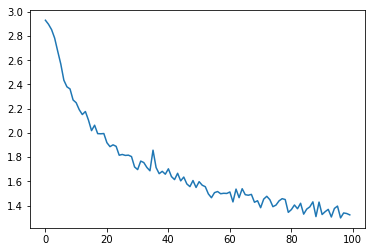

In [17]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

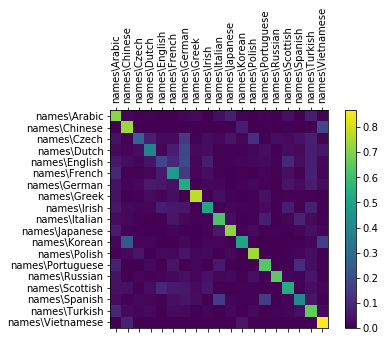

In [18]:
confusion = torch.zeros(n_categories, n_categories)
n_confusion = 10000

def evaluate(line_tensor):
    hidden = rnn.init_hidden()
    
    for i in range(line_tensor.size()[0]):
        output, hidden = rnn(line_tensor[i], hidden)
    
    return output

for i in range(n_confusion):
    category, line, category_tensor, line_tensor = random_training_pair()
    output = evaluate(line_tensor)
    guess, guess_i = category_from_output(output)
    category_i = all_categories.index(category)
    confusion[category_i][guess_i] += 1

for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)


ax.set_xticklabels([''] + all_categories, rotation=90)
ax.set_yticklabels([''] + all_categories)

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.show()

In [19]:
def predict(input_line, n_predictions=3):
    print('\n> %s' % input_line)
    output = evaluate(Variable(line_to_tensor(input_line)))
    
    topv, topi = output.data.topk(n_predictions, 1, True)
    predictions = []
    
    for i in range(n_predictions):
        value = topv[0][i]
        category_index = topi[0][i]
        print('(%.2f) %s' % (value, all_categories[category_index]))
        predictions.append([value, all_categories[category_index]])
    
predict('Hilmi')
predict('Jack')
predict('Cho')


> Hilmi
(-1.05) names\Turkish
(-1.29) names\Italian
(-2.28) names\German

> Jack
(-1.58) names\Korean
(-1.86) names\Czech
(-1.87) names\Polish

> Cho
(-0.64) names\Vietnamese
(-1.37) names\Korean
(-1.82) names\Chinese
